In [1]:
%matplotlib inline

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!pip install -q tensorflow-gpu==2.0.0-beta0

import glob
import os
import re
import time

import matplotlib.pyplot as plt
import tensorflow as tf

from IPython.display import clear_output

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

     |████████████████████████████████| 348.9MB 48kB/s 
     |████████████████████████████████| 3.1MB 48.2MB/s 
     |████████████████████████████████| 501kB 55.1MB/s 
     |████████████████████████████████| 61kB 27.6MB/s 
Found GPU at: /device:GPU:0


In [0]:
# Set these to be the directories containing the data subdirectories
# (so xzIntensity and OMAG BScans are 2 levels down from this dir).
TRAIN_DATA_DIR = '/content/gdrive/My Drive/data/train'
TEST_DATA_DIR = '/content/gdrive/My Drive/data/test'

# Shuffle buffer size (>= dataset size for perfect shuffling)
BUFFER_SIZE = 400

# This should actually be much more but also that will blow up the RAM
EPOCHS = 4

In [0]:
# Decodes a grayscale PNG, returns a 2D tensor.
def load_image(file_name):
    image = tf.io.read_file(file_name)
    image = tf.image.decode_png(image)
    return image

In [0]:
# Returns a pair of tensors containing the given B-scan and its
# corresponding OMAG. |bscan_path| should be in directory 'xzIntensity'
# and its parent directory should contain 'OMAG Bscans'. Scan files
# should be named <num>.png (no leading 0s), with a 4-to-1 ratio of
# B-scans to OMAGs.
# (OMAG Bscans/1.png corresponds to xzIntensity/{1,2,3,4}.png.)
def get_images(bscan_path):
    bscan_img = load_image(bscan_path)
    
    path_components = re.search(
        r'^(.*)xzIntensity/(\d+)\.png$', bscan_path)
    
    dir_path = path_components.group(1)
    bscan_num = int(path_components.group(2))
    
    omag_num = ((bscan_num-1) // 4) + 1
    
    omag_img = load_image(
        os.path.join(dir_path, 'OMAG Bscans',
                     '{}.png'.format(omag_num)))
    
    bscan_img = tf.cast(bscan_img, tf.float32)
    omag_img = tf.cast(omag_img, tf.float32)
    
    bscan_img = (bscan_img / 127.5) - 1
    omag_img = (omag_img / 127.5) - 1
    
    return bscan_img, omag_img

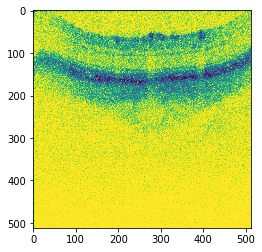

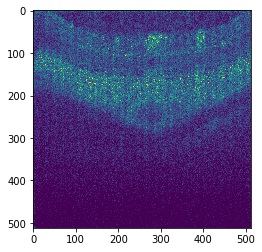

In [7]:
# Test dump input 1 from the '2015-08-11 Images50'
# dataset.

input_img, output_img = get_images(
    os.path.join(TRAIN_DATA_DIR, '2015-08-11 Images50', 'xzIntensity', '1.png'))
    
plt.figure()
plt.imshow(tf.squeeze(input_img))
plt.figure()
plt.imshow(tf.squeeze(output_img))

In [0]:
# Build a tf.data.Dataset of input B-scan and output OMAG images in the given directory.
def get_dataset(data_dir):
    dataset = tf.data.Dataset.from_generator(
        lambda: map(get_images, glob.glob(
            os.path.join(data_dir, '*', 'xzIntensity', '*.png'))),
        output_types=(tf.float32, tf.float32))
    # silently drop data that causes errors (e.g. corresponding OMAG file doesn't exist)
    dataset = dataset.apply(tf.data.experimental.ignore_errors())
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(1)
    return dataset

train_dataset = get_dataset(TRAIN_DATA_DIR)
test_dataset = get_dataset(TEST_DATA_DIR)

W0612 03:16:01.752337 139813699315584 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:504: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


# pix2pix generator

In [0]:
OUTPUT_CHANNELS = 1

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
            kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(input_img, 0))
print (down_result.shape)

(1, 256, 256, 3)


In [0]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 512, 512, 3)


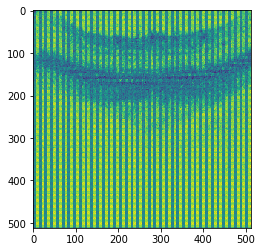

In [0]:
def Generator():
  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[None,None,1])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

generator = Generator()

gen_output = generator(input_img[tf.newaxis,...], training=False)
plt.imshow(tf.squeeze(gen_output[0,...]))

# pix2pix discriminator

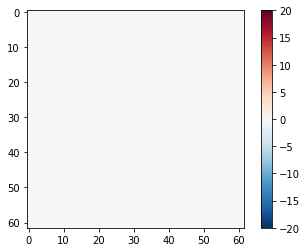

In [0]:
inp = input_img

def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, 1], name='input_image')
  tar = tf.keras.layers.Input(shape=[None, None, 1], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

discriminator = Discriminator()
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [0]:
LAMBDA = 100

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# training

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
def generate_images(model, test_input, tar):
  # the training=True is intentional here since
  # we want the batch statistics while running the model
  # on the test dataset. If we use training=False, we will get
  # the accumulated statistics learned from the training dataset
  # (which we don't want)
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(tf.squeeze(display_list[i]) * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [0]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss,
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    for inp, tar in test_dataset.take(1):
            generate_images(generator, inp, tar)

    for input_image, target in dataset:
        train_step(input_image, target)

    for inp, tar in test_dataset.take(1):
            generate_images(generator, inp, tar)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
checkpoint.save(file_prefix = checkpoint_prefix)

'./training_checkpoints/ckpt-1'

W0612 03:04:54.389014 140382193104768 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:182: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


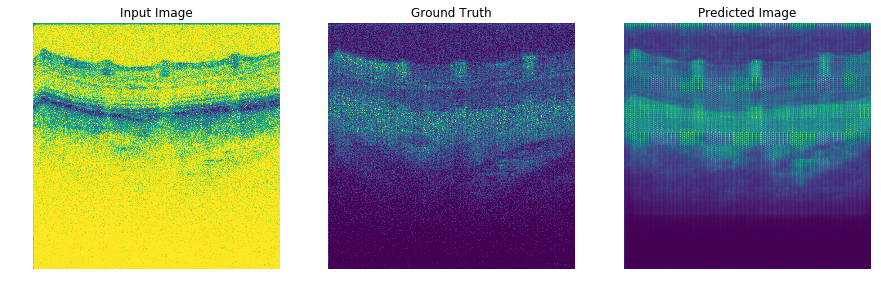

Time taken for epoch 1 is 82.1827700138092 sec



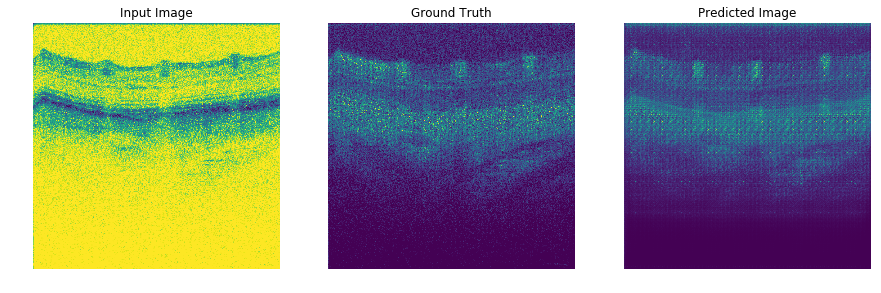

Time taken for epoch 2 is 74.45523500442505 sec



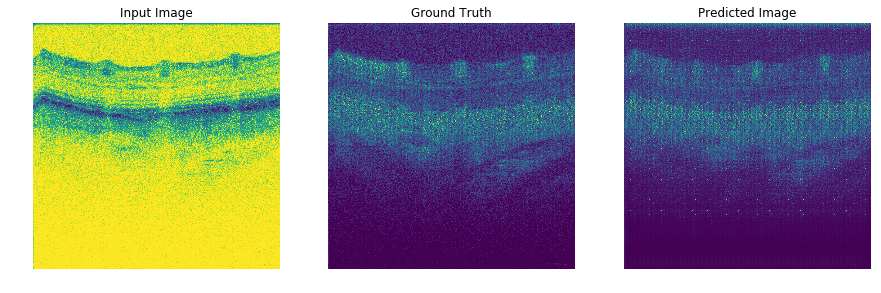

Time taken for epoch 3 is 75.71325278282166 sec



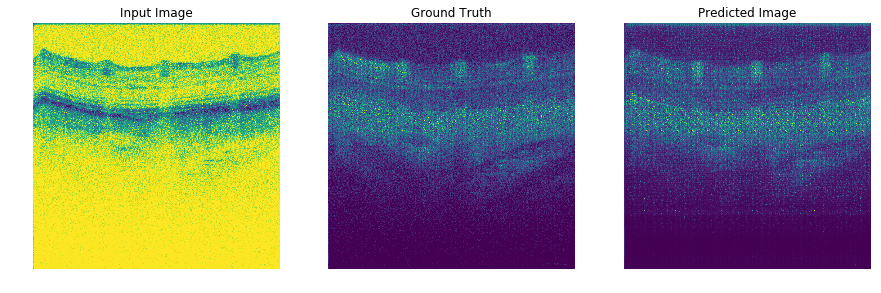

Time taken for epoch 4 is 76.14564108848572 sec



In [0]:
train(train_dataset, EPOCHS)